# Retrieve CMIP6 data
## 2 m temperature, snowfall, and rainfall over Antarctica in SSP1, 3, and 5

In [1]:
import intake
import xarray as xr
import pprint 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime
from dateutil.relativedelta import relativedelta, MO
from datetime import timedelta
from glob import glob

import matplotlib.path as mpath
from matplotlib.gridspec import GridSpec
import geopandas as gpd
import cartopy
import cartopy.crs as ccrs
crs_sp = ccrs.SouthPolarStereo(central_longitude=0)
crs_ll = ccrs.PlateCarree()

In [2]:
def convert_to_datetime64(da):
    old_time = da.time.values
    new_time = old_time.astype("datetime64[ns]")
    da['time']=new_time
    return da

#subtract 3 hours:
def subtract_3_hours(da):
    time = da.time.values
    new_dates = list()
    for d in time:
        new_d = pd.Timestamp(d) - timedelta(hours=3)
        new_dates.append(new_d.to_datetime64())

    da['time'] = new_dates
    return da

def get_summer(da):
    da_sum = da.where(da.time.dt.month.isin([1,2,12]), drop=True)
    new_dates = list()
    for d in da_sum.time.values:
        new_d = pd.Timestamp(d) + relativedelta(months=+1)
        new_dates.append(new_d.to_datetime64())
        
    da_sum['time'] = new_dates
    
    return da_sum

In [300]:
def get_temperature(model, scen):
    cat = col.search(experiment_id=scen, variable_id='tas', source_id=model, table_id = 'Amon',member_id = ensembles)
    dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True}, cdf_kwargs={'chunks': {}})
    key = list(dset_dict.keys())[0]
    tas = dset_dict[key]['tas']

    #tas_emean = convert_to_datetime64(tas)
    if model == 'ACCESS-CM2':
        tas_emean = tas.sel(time = slice(datetime.strptime('2015-01-01 0:0:0', '%Y-%m-%d %H:%M:%S'), datetime.strptime('2100-01-01 0:0:0', '%Y-%m-%d %H:%M:%S'))).sel(lat = slice(-90,-60)).mean(dim = 'member_id')
    else:
        tas_emean = tas.sel(time = slice('2015-01-01','2099-12-31')).sel(lat = slice(-90,-60)).mean(dim = 'member_id')
    tas_emean2 = convert_to_datetime64(tas_emean)
    #tas_emean2 = tas_emean2.resample(time='M').mean()

    new_da = xr.DataArray(
        data=tas_emean2.values,
        dims=["time", "lat", "lon"],
        coords=dict(
            lon=tas_emean2.lon.values,
            lat=tas_emean2.lat.values,
            time=tas_emean2.time.values,),)
    return new_da

def get_precip(model, scen):
    cat = col.search(experiment_id=scen, variable_id='pr', source_id=model, table_id = 'Amon',member_id = ensembles)
    dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True}, cdf_kwargs={'chunks': {}})
    key = list(dset_dict.keys())[0]
    pr = dset_dict[key]['pr']

    #pr_emean = convert_to_datetime64(pr)
    if model == 'ACCESS-CM2':
        pr_emean = pr.sel(time = slice(datetime.strptime('2015-01-01 0:0:0', '%Y-%m-%d %H:%M:%S'), datetime.strptime('2100-01-01 0:0:0', '%Y-%m-%d %H:%M:%S'))).sel(lat = slice(-90,-60)).mean(dim = 'member_id')
    else:
        pr_emean = pr.sel(time = slice('2015-01-01','2100-01-01')).sel(lat = slice(-90,-60)).mean(dim = 'member_id')
    pr_emean2 = convert_to_datetime64(pr_emean)

    pr_emean_units = pr_emean2*pr_emean2.time.dt.daysinmonth*24*3600 #convert from kg/m2/s to kg/m2/month
    
    new_da = xr.DataArray(
        data=pr_emean_units.values,
        dims=["time", "lat", "lon"],
        coords=dict(
            lon=pr_emean_units.lon.values,
            lat=pr_emean_units.lat.values,
            time=pr_emean_units.time.values,
        ),)
    return new_da

def get_wind(model, scen):
    cat = col.search(experiment_id=scen, variable_id='sfcWind', source_id=model, table_id = 'Amon', member_id = ensembles)
    dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True}, cdf_kwargs={'chunks': {}})
    key = list(dset_dict.keys())[0]
    wind = dset_dict[key]['sfcWind']

    #wind_emean = convert_to_datetime64(wind)
    if model in ['ACCESS-CM2','IPSL-CM6A-LR']:
        wind_emean = wind.sel(time = slice(datetime.strptime('2015-01-01 0:0:0', '%Y-%m-%d %H:%M:%S'), datetime.strptime('2100-01-01 0:0:0', '%Y-%m-%d %H:%M:%S'))).sel(lat = slice(-90,-60)).mean(dim = 'member_id')
    else:
        wind_emean = wind.sel(time = slice('2015-01-01','2100-01-01')).sel(lat = slice(-90,-60)).mean(dim = 'member_id')
    
    wind_emean2 = convert_to_datetime64(wind_emean)

    new_da = xr.DataArray(
        data=wind_emean2.values,
        dims=["time", "lat", "lon"],
        coords=dict(
            lon=wind_emean2.lon.values,
            lat=wind_emean2.lat.values,
            time=wind_emean2.time.values,),)
    return new_da



def get_topo(model):
    cat1 = col.search(variable_id='orog', source_id = model, table_id = 'fx', experiment_id = 'piControl')

    dset_dict = cat1.to_dataset_dict(zarr_kwargs={'consolidated': True}, 
                                        cdf_kwargs={'chunks': {}})
    key = list(dset_dict.keys())[0]
    var1 = dset_dict[key]['orog'].mean(dim = 'member_id')
    var1 = var1.sel(lat = slice(-90,-60))
    
    new_da = xr.DataArray(
        data=var1.values,
        dims=["lat", "lon"],
        coords=dict(
            lon=var1.lon.values,
            lat=var1.lat.values,),)
    
    return new_da

def get_land(model):
    cat1 = col.search(variable_id='sftlf', source_id = model, table_id = 'fx', experiment_id = 'piControl')

    dset_dict = cat1.to_dataset_dict(zarr_kwargs={'consolidated': True}, 
                                        cdf_kwargs={'chunks': {}})
    key = list(dset_dict.keys())[0]
    var1 = dset_dict[key]['sftlf'].mean(dim = 'member_id')
    var1 = var1.sel(lat = slice(-90,-60))
    new_da = xr.DataArray(
        data=var1.values,
        dims=["lat", "lon"],
        coords=dict(
            lon=var1.lon.values,
            lat=var1.lat.values,),)
    return new_da  

## Open the CMIP6 archive json file

In [37]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)

In [38]:
url = "/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cmip6.json"
col2 = intake.open_esm_datastore(url)
# col

In [291]:
ensembles = cat.df.member_id.values

## Retrieve desired data

In [111]:
model_files = glob('/glade/work/devond/FAC/hist/*.nc')
models = list()
for f in model_files:
    model = f.split('/')[-1][:-8]
    models.append(model)
    
different_models = []#['IPSL-CM6A-LR','ACCESS-ESM1-5','HadGEM3-GC31-LL','NorESM2-MM','HadGEM3-GC31-MM','ACCESS-CM2','E3SM-1-1','GISS-E2-1-H','GFDL-CM4','AWI-CM-1-1-MR','CNRM-ESM2-1']#['CESM2-WACCM', 'CanESM5']
#models = ['GFDL-CM4']
# years = np.arange(2015, 2101)

In [305]:
ensembles = ['r13i1p1f1', 'r6i1p1f1', 'r11i1p1f1', 'r15i1p1f1', 'r1i1p1f1','r4i1p1f1', 'r9i1p1f1']

In [308]:
scenario = 'ssp5'
if scenario=='ssp1':scen = 'ssp126'
elif scenario=='ssp3':scen = 'ssp370'
elif scenario=='ssp5':scen = 'ssp585'

done_models = glob(f'/glade/work/devond/FAC/{scenario}/*.nc')
for model in ['EC-Earth3']:#models:
    print(model)
    if f'/glade/work/devond/FAC/{scenario}/{model}_{scenario}.nc' not in done_models and model not in different_models:
        tas = get_temperature(model, scen)
        pr = get_precip(model, scen)
        wind = get_wind(model, scen)
        # topo = get_topo(model)
        # land = get_land(model)

        ds = xr.Dataset(
            data_vars=dict(
                ta=(["time", "lat","lon"], tas.values),
                pr=(["time", "lat","lon"], pr.values),
                wind=(["time", "lat","lon"], wind.values),
                # topo=(["lat","lon"], topo.values),
                # land=(["lat","lon"], land.values),
            ),
            coords=dict(
                time=tas.time.values,
                lat=tas.lat.values,
                lon=tas.lon.values,
            ),
        )

        ds.to_netcdf(f'/glade/work/devond/FAC/{scenario}/{model}_{scenario}.nc')

EC-Earth3

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [8]:
def plot_antarctica(ax, lat):
    coast_line = gpd.read_file('/glade/work/devond/shp_files/Coastline_Antarctica_v2.shp')
    grounding_line = gpd.read_file('/glade/work/devond/shp_files/GroundingLine_Antarctica_v2.shp')
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.51
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    ax.add_geometries(coast_line['geometry'], crs = ccrs.SouthPolarStereo(central_longitude=0), facecolor='none', edgecolor='black', linewidth = 0.5)
    ax.add_geometries(grounding_line['geometry'], crs = ccrs.SouthPolarStereo(central_longitude=0), facecolor='none', edgecolor='black', linewidth = 0.5)
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([-180, 180, -90, lat], ccrs.PlateCarree())
    return

/glade/work/devond/conda-envs/my_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


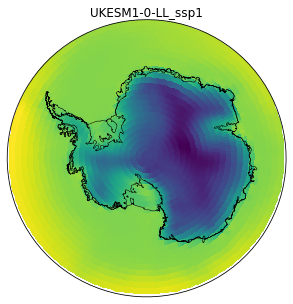

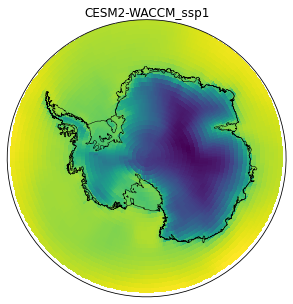

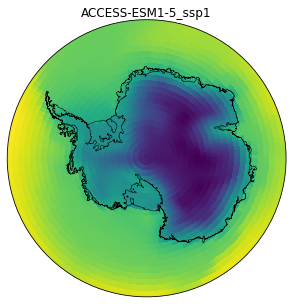

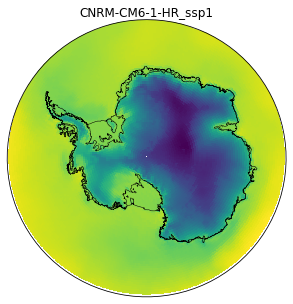

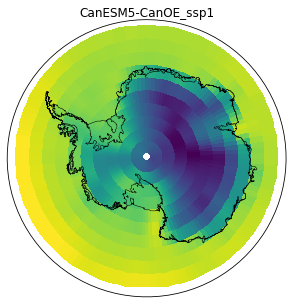

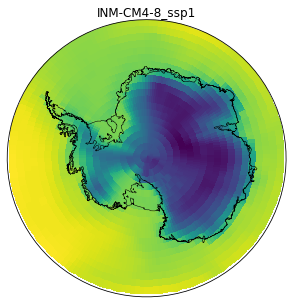

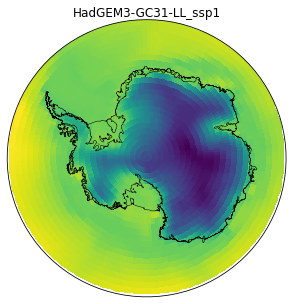

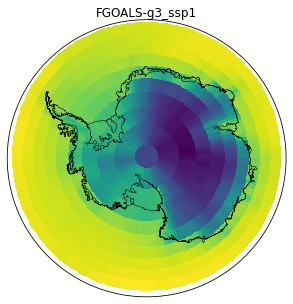

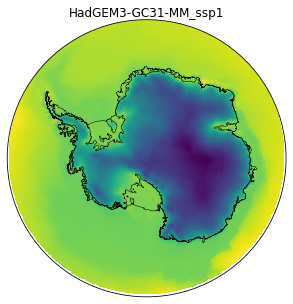

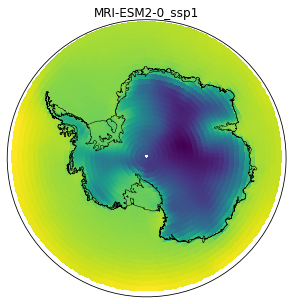

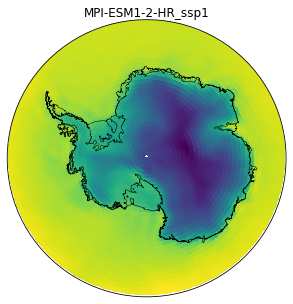

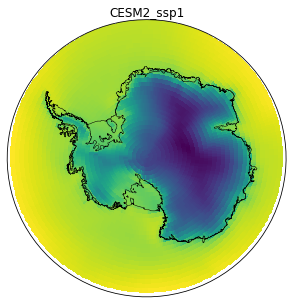

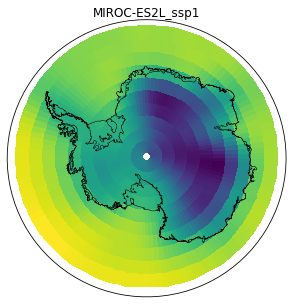

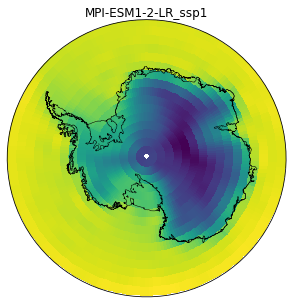

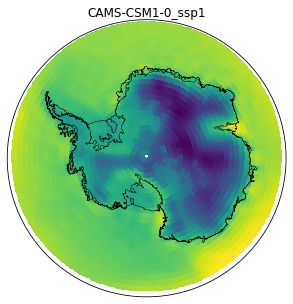

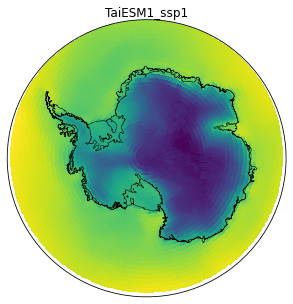

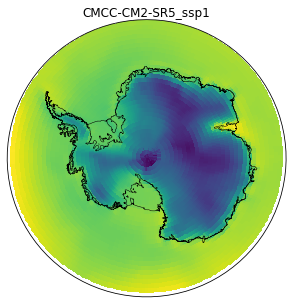

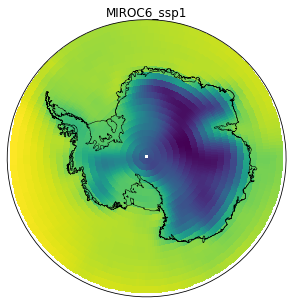

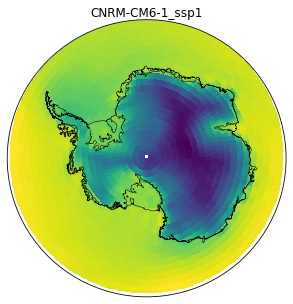

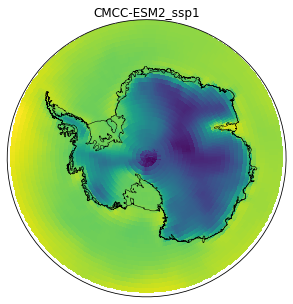

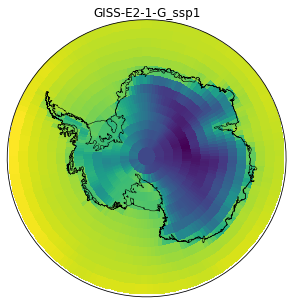

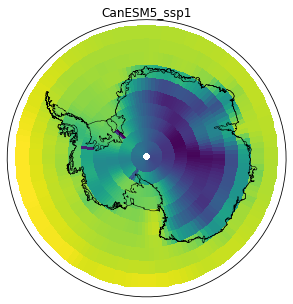

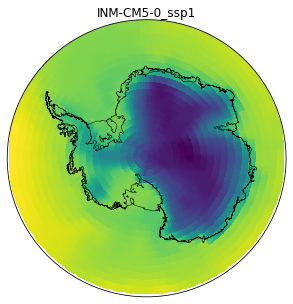

In [13]:
for model in done_models:
    d = xr.open_dataset(model)
    
    fig = plt.figure(figsize = (5,5))
    gs=GridSpec(1,1)
    ax2 = plt.subplot(gs[0],projection=crs_sp)
    plot_antarctica(ax2,-60)
    im2 = ax2.pcolormesh(d.lon, d.lat, d.isel(time=0).ta,transform = crs_ll)
    ax2.set_title(model.split('/')[-1][0:-3])